<a href="https://colab.research.google.com/github/KotagiriRohan/MicroGrad/blob/main/Micro_gradient_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import graphviz

In [13]:
def draw_graph(root):
    dot = graphviz.Digraph(comment="Connection Graph", graph_attr={'rankdir': 'LR'})
    nodes = set()

    def build(node):
        if node not in nodes:
            nodes.add(node)
            dot.node(name=str(id(node)), label="{%s| data %.4f | grad %.4f }" % (node.lable,node.data, node.grad), shape='record')
            if node.op:
                dot.node(name=str(id(node)) + node.op, label=node.op)
                dot.edge(str(id(node)) + node.op, str(id(node)))
            for child in node.prev:
                dot.edge(str(id(child)), str(id(node)) + node.op)
                build(child)

    build(root)
    return dot


class Value:
    def __init__(self, data, children=(), op='', lable=''):
        self.data = data
        self.prev = set(children)
        self.lable = lable
        self.grad = 0.0
        self._backward = lambda: None
        self.op = op

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):  # self / other
        return self * other ** -1

    def __pow__(self, power, modulo=None):
        assert isinstance(power, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** power, (self,), f'**{power}')

        def _backward():
            self.grad += (power * self.data**(power-1)) * out.grad

        out._backward = _backward
        return out

    def __neg__(self):  # -self
        return self * Value(-1, lable="negitive")

    def __radd__(self, other): # other + self
        return self + other

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other):
        return self * other

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, children={self.prev})"

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()



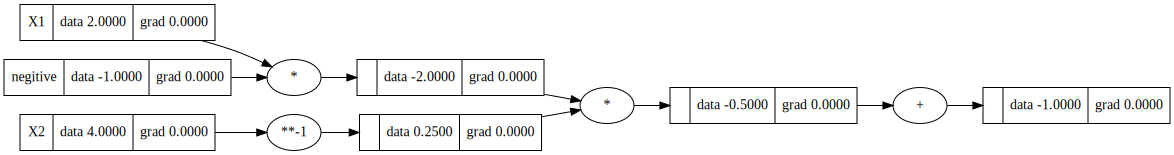

In [19]:
x = -Value(2, lable="X1") / Value(4,lable="X2")
y = x + x
draw_graph(y)

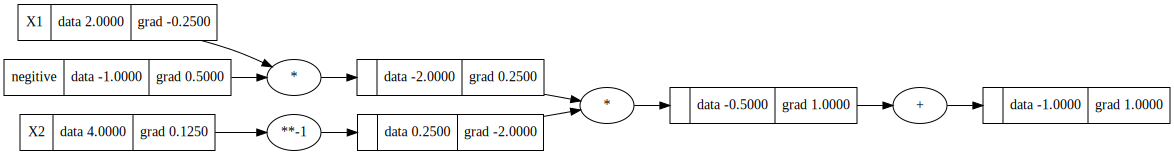

In [20]:
y.backward()
draw_graph(y)